In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import glob
import pickle
import numpy
from scipy import ndimage, signal, interpolate
import matplotlib
matplotlib.use('PDF')
from galpy.util import bovy_conversion, bovy_plot, save_pickles
import gd1_util
from gd1_util import R0, V0
import simulate_streampepper
import bispectrum
import seaborn as sns
from matplotlib import cm, pyplot
from matplotlib.ticker import FuncFormatter, NullFormatter
%pylab inline
scaling= 'spectrum'
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Analysis of simulations with stream peppering for a GD-1 like stream in observed space

In [3]:
# Load the smooth and peppered stream, only need 1 time-sampling, 
# bc only use it to convert to obs. space at present
sdf_smooth= gd1_util.setup_gd1model()
pepperfilename= 'gd1pepper1sampling.pkl'
if os.path.exists(pepperfilename):
    with open(pepperfilename,'rb') as savefile:
        sdf_pepper= pickle.load(savefile)
else:
    timpacts= simulate_streampepper.parse_times('1sampling',9.)
    sdf_pepper= gd1_util.setup_gd1model(timpact=timpacts,
                                        hernquist=True)
    save_pickles(pepperfilename,sdf_pepper)

In [4]:
smooth_track= []
for coord in range(6):
    smooth_track.append(\
        interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                 sdf_smooth._interpolatedObsTrackLB[:,coord]))
smooth_ll= interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedObsTrackLB[:,0],
                                                    sdf_smooth._interpolatedThetasTrack)
def convert_dens_to_obs(apars,dens,dens_smooth,mO):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
    OUTPUT:
        (longitude,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
def convert_track_to_obs(apars,mO,coord):
    """
    NAME:
        convert_track_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        mO - mean parallel frequency (1D)
        coord - coordinate to convert to (1: latitude, 2: distance, 3: vlos, 4: pmll, 5: pmbb)
    OUTPUT:
        (longitude,(track-smooth)[coord])
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    # Interpolate
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipcoord= interpolate.InterpolatedUnivariateSpline(apars,mT[coord])
    outll= numpy.linspace(numpy.amin(mT[0]),numpy.amax(mT[0]),len(apars))
    return (outll,ipcoord(ipll(outll))-smooth_track[coord](smooth_ll(outll)))    
def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2])
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2])
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii])
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii])
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))

In [5]:
def plot_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',err1=err)
    loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err is None: loglog(px,py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1='dens',coord2='dens')
        fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                   fill=False,fill_color='0.65',fill_zorder=0,
                   err_color=sns.color_palette()[2],err_zorder=0,
                   errs=[None,None,None],
                   scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,coord1=1,err1=errs[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,coord1=2,err1=errs[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,coord1=3,err1=errs[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,coord1=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def plot_all_track_dens(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        err1=None,err2s=[None,None,None],
                        scale=1.):
    subplot(1,3,1)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=1,err1=err1,err2=err2s[0])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[0] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=1)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=2,err1=err1,err2=err2s[1])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[1] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=2)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py, py_err= median_csd(filename,filename2=filename.replace('dens','omega'),
                               coord1='dens',coord2=3,err1=err1,err2=err2s[2])
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if not err2s[2] is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,filename2=filename.replace('dens','omega'),
                                               scatter=True,coord1='dens',coord2=3)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.01,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{bb}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{DD}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{V_{\mathrm{los}} V_{\mathrm{los}}}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def set_ranges_and_labels_cross():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{|\delta b|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{|\delta D|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta V_{\mathrm{los}}|}$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(0.001,10.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar_dens(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_discrete_colorbar_dens(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.775,0.135,0.05,0.815])
    else:
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.925, 0.13, 0.075, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_discrete_colorbar(vmin,vmax,clabel,ticks,save_figures=False,fmt=r'$%.1f$'):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                                  norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=fmt,
                       ticks=ticks)
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## Density

In [6]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_multtime')

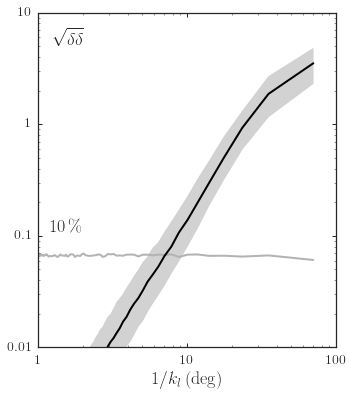

In [7]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11/3.,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.15,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
          color='k',zorder=1,ls='-',err_color='0.7',
          fill=True,err=0.1)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$10\,\%$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_densObs.pdf'))

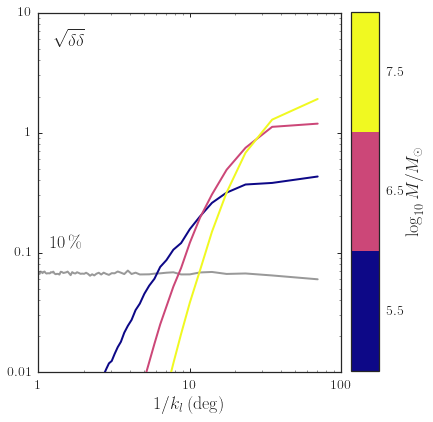

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(14.5/3.,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.1,right=0.75,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16/3.,6)
plot_dens(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
          color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,
          err=0.1,err_color='0.6')
plot_dens(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
          color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_dens(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
          color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels_dens()
bovy_plot.bovy_text(1.2,0.11,r'$10\,\%$',size=18.)
if not save_figures: tight_layout()
add_discrete_colorbar_dens(5.5,7.5,r'$\log_{10} M/M_\odot$',
                           [5.5,6.5,7.5],
                           save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_densObs_massranges.pdf'))

## Track autocorrelation

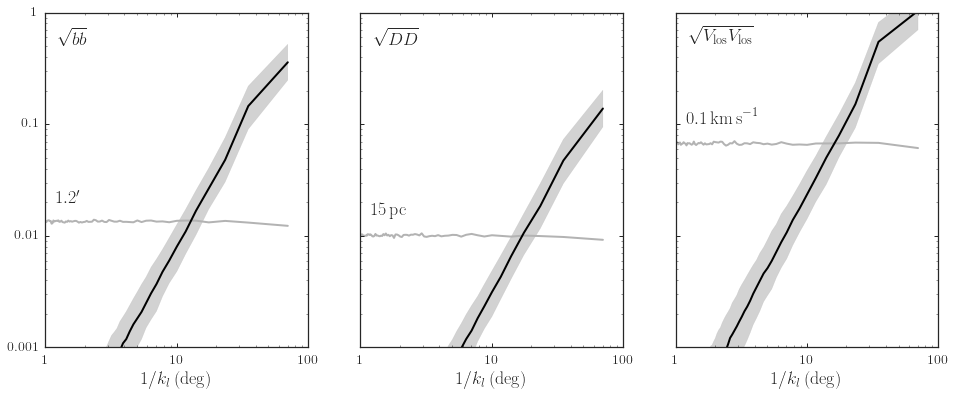

In [9]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_omega.dat'),
               color='k',zorder=1,ls='-',err_color='0.7',
               fill=True,errs=[0.02,0.015,0.1])
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.02,r"$1.2'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.015,r'$15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.1,r'$0.1\,\mathrm{km\,s}^{-1}$',size=18.)
set_ranges_and_labels()
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_trackObs.pdf'))

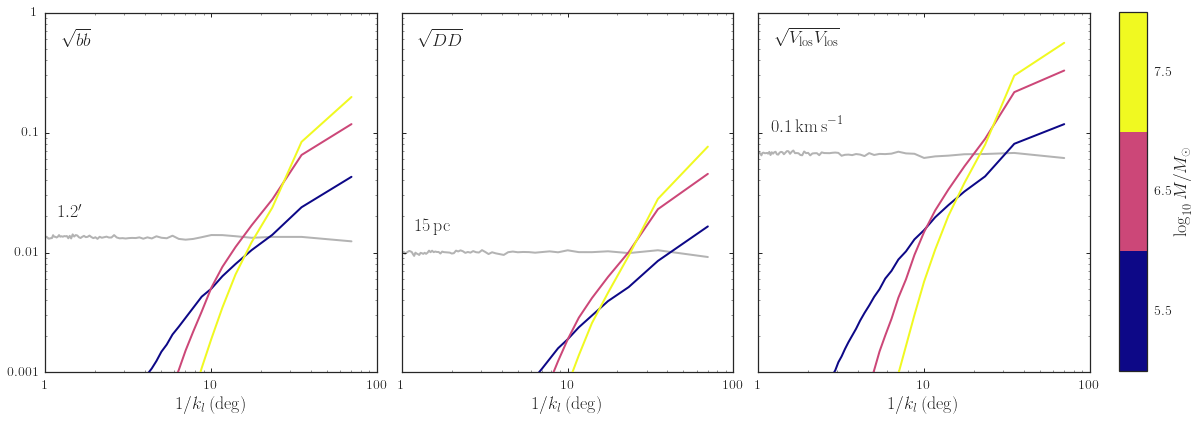

In [10]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_omega.dat'),
               color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,err_color='0.7',
               errs=[0.02,0.015,0.1])
plot_all_track(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_omega.dat'),
               color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all_track(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_omega.dat'),
               color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels()
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.02,r"$1.2'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.015,r'$15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.1,r'$0.1\,\mathrm{km\,s}^{-1}$',size=18.)
if not save_figures: tight_layout()
add_discrete_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',
                      [5.5,6.5,7.5],save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_trackObs_massranges.pdf'))

## Density-track cross-correlation

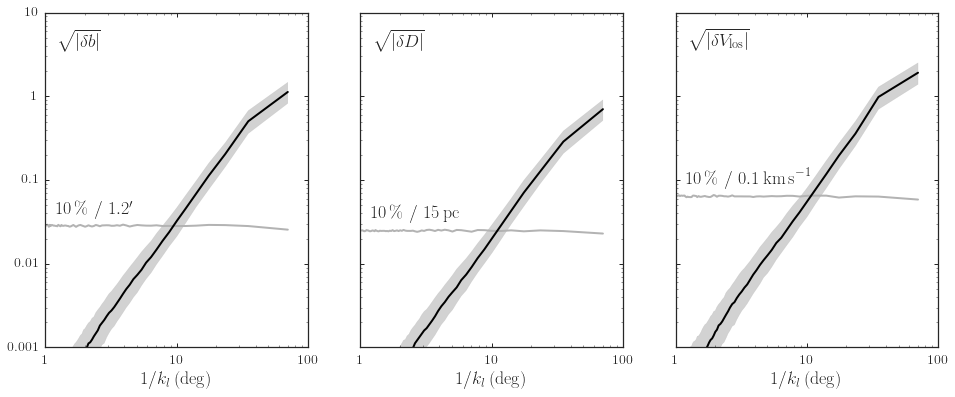

In [11]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(13,5.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.975,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track_dens(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
                    color='k',zorder=1,ls='-',err_color='0.7',
                    fill=True,err1=0.1,err2s=[0.02,0.015,0.1])
set_ranges_and_labels_cross()
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.04,r"$10\,\%\ / \ 1.2'$",size=18.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.035,r'$10\,\%\ / \ 15\,\mathrm{pc}$',size=18.)
subplot(1,3,3)
bovy_plot.bovy_text(1.2,0.09,r'$10\,\%\ / \ 0.1\,\mathrm{km\,s}^{-1}$',size=18.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_crossObs.pdf'))

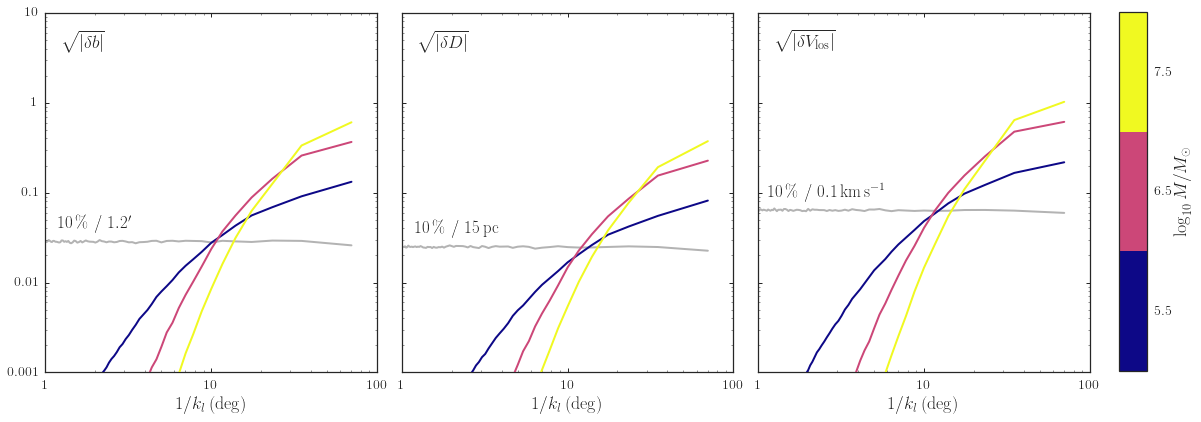

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all_track_dens(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
               color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,err_color='0.7',
               err1=0.1,err2s=[0.02,0.015,0.1])
plot_all_track_dens(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
               color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all_track_dens(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
               color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels_cross()
if not save_figures: tight_layout()
add_discrete_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',
                      [5.5,6.5,7.5],save_figures=save_figures)
subplot(1,3,1)
bovy_plot.bovy_text(1.2,0.04,r"$10\,\%\ / \ 1.2'$",size=17.)
subplot(1,3,2)
bovy_plot.bovy_text(1.2,0.035,r'$10\,\%\ / \ 15\,\mathrm{pc}$',size=17.)
subplot(1,3,3)
bovy_plot.bovy_text(1.15,0.09,r'$10\,\%\ / \ 0.1\,\mathrm{km\,s}^{-1}$',size=17.)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_crossObs_massranges.pdf'))

## Bispectra

In [13]:
def median_bispectrum(filename,ind,scatter=False,limitnsim=None,err=None,poisson=False):
    # Compute the median bispectrum
    data1= read_data(filename)
    if 'dens' in filename:
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    apars= data1[0]
    tdata= (data1[2:]/data1[1]).T
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    if 'dens' in filename:
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2])
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],1)
    Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
    if not limitnsim is None: nsim= limitnsim
    ppyr= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyr_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    ppyi_err= numpy.empty((nsim,len(px[len(Bspec)//2:])))
    for ii in range(nsim):
        if 'dens' in filename:
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii])
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],1)
        Bspec, px= bispectrum.bispectrum(numpy.vstack((tdata1,tdata1)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
        ppyr[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
        ppyi[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
        # Same for error
        if not err is None:
            if 'dens' in filename and poisson:
                equiv_lambda= int(numpy.ceil(1./err**2.))
                tmock= (numpy.random.poisson(lam=equiv_lambda,size=len(ll))-equiv_lambda)/float(equiv_lambda)
            else:
                tmock= err*numpy.random.normal(size=len(ll))
            Bspec, px= bispectrum.bispectrum(numpy.vstack((tmock,tmock)).T,nfft=len(tdata1),wind=7,nsamp=1,overlap=0)
            ppyr_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].real)
            ppyi_err[ii]= numpy.fabs(Bspec[len(Bspec)//2+ind,len(Bspec)//2:].imag)
    ppyr_err.sort(axis=0)
    ppyi_err.sort(axis=0)
    if not scatter:
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                    numpy.nanmedian(ppyr,axis=0),
                    numpy.nanmedian(ppyi,axis=0),
                    ppyr_err[int(numpy.round(0.9545*nsim))],
                    ppyi_err[int(numpy.round(0.9545*nsim))])
    else:
        ppyr.sort(axis=0)
        ppyi.sort(axis=0)
        return (1./px[len(Bspec)//2:]*(ll[1]-ll[0]),
                numpy.nanmedian(ppyr,axis=0),
                numpy.nanmedian(ppyi,axis=0),
                ppyr[int(numpy.round(0.25*nsim))],
                ppyr[int(numpy.round(0.75*nsim))],
                ppyi[int(numpy.round(0.25*nsim))],
                ppyi[int(numpy.round(0.75*nsim))])

In [14]:
def plot_all_bispectrum(filename,color=sns.color_palette()[0],zorder=1,ls='-',
                        fill=False,fill_color='0.65',fill_zorder=0,
                        err_color=sns.color_palette()[2],err_zorder=0,
                        scale=1.,ind=5,nsim=None,errs=[0.1,0.02],
                        poisson=False,err_lw=2.,err_ls='-'):
    subplot(1,4,1)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename,ind,
                                                      limitnsim=nsim,err=errs[0],poisson=poisson)
    loglog(px,scale*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyr_err,lw=err_lw,color=err_color,zorder=err_zorder,ls=err_ls)
    subplot(1,4,2)
    loglog(px,scale*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,scale*pyi_err,lw=err_lw,color=err_color,zorder=err_zorder,ls=err_ls)
    if fill:
        subplot(1,4,1)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename,ind,scatter=True,
                                                                     limitnsim=nsim)
        fill_between(plotx,scale*lowr,scale*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,2)
        fill_between(plotx,scale*lowi,scale*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    if poisson: errs= [None,None] # Don't plot the other errors with poisson == True
    subplot(1,4,3)
    px, pyr, pyi, pyr_err, pyi_err= median_bispectrum(filename.replace('dens','omega'),ind,
                                                      limitnsim=nsim,err=errs[1])
    loglog(px,100.*pyr,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyr_err,lw=2.,color=err_color,zorder=err_zorder,ls=err_ls)
    subplot(1,4,4)
    loglog(px,100.*pyi,lw=2.,color=color,zorder=zorder,ls=ls)
    if not errs[0] is None: loglog(px,100.*pyi_err,lw=2.,color=err_color,zorder=err_zorder,ls=err_ls)
    if fill:
        subplot(1,4,3)
        plotx, dum, dum, lowr, highr, lowi, highi= median_bispectrum(filename.replace('dens','omega'),
                                                                     ind,scatter=True,limitnsim=nsim)
        fill_between(plotx,100.*lowr,100.*highr,color=fill_color,zorder=fill_zorder,alpha=0.5)
        subplot(1,4,4)
        fill_between(plotx,100.*lowi,100.*highi,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels_bispectrum(low=0.0001,high=20.):
    subplot(1,4,1)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,4,2)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(\delta\delta\delta)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,3)
    bovy_plot.bovy_text(r'$|\mathrm{Real}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,4,4)
    bovy_plot.bovy_text(r'$|\mathrm{Imag}(bbb)|$',top_left=True,size=18.)
    xlabel(r'$1/k_{l}\,(\mathrm{deg})$')
    ylim(low,high)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def add_colorbar_bispectrum(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.925)
        cbar_ax = fig.add_axes([0.99, 0.13, 0.025, 0.845])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None
def add_discrete_colorbar_bispectrum(vmin,vmax,clabel,ticks,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.925)
        cbar_ax = fig.add_axes([0.99, 0.13, 0.025, 0.845])
    tcmap = matplotlib.colors.ListedColormap([cmap(f) for f in numpy.linspace(0.,1.,len(ticks))])
    dtick= (ticks[1]-ticks[0])
    sm = pyplot.cm.ScalarMappable(cmap=tcmap,
                                  norm=pyplot.Normalize(vmin=vmin-0.5*dtick,vmax=vmax+0.5*dtick))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$',ticks=ticks)
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



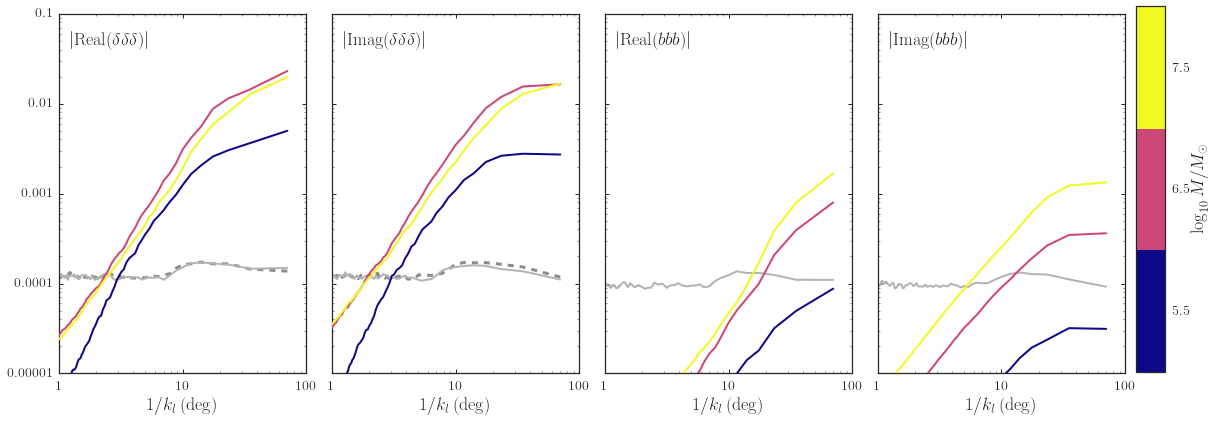

In [15]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
                    color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7,nsim=None,
                    err_color='0.7',err_zorder=1)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
                    color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7,nsim=None,
                    err_color='0.55',poisson=True,err_ls='--',err_lw=3.)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
                    color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7,nsim=None,
                    errs=[None,None])
set_ranges_and_labels_bispectrum(low=0.00001,high=.1)
if not save_figures: tight_layout()
add_discrete_colorbar_bispectrum(5.5,7.5,r'$\log_{10} M/M_\odot$',
                                 [5.5,6.5,7.5],save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_bispectrum_obs_massranges.pdf'))
else:
    tight_layout()

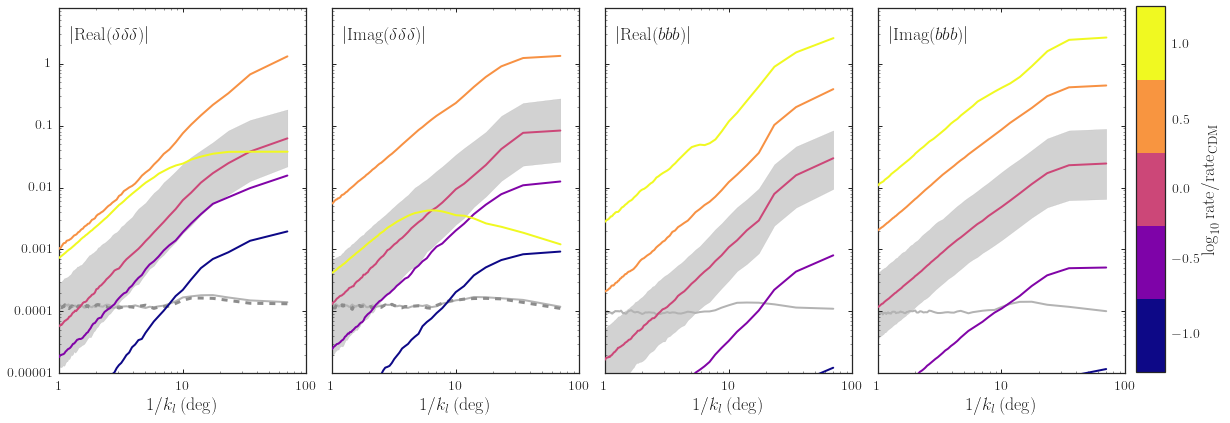

In [16]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.plasma
if save_figures:
    figsize(12,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.1)
else:
    figsize(16,6)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
                    color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True,nsim=None,
                    err_color='0.7')
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp33_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9,nsim=None,
                    err_color='0.55',poisson=True,err_ls='--',err_lw=3.)
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdm3_5-9_dens.dat'),
                    color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10,nsim=None,
                    errs=[None,None])
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp1_5-9_dens.dat'),
                    color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9,nsim=None,
                    errs=[None,None])
plot_all_bispectrum(os.path.join(basefilename,'gd1_t64sampling_X5_cdm10_5-9_dens.dat'),
                    color=color_from_colormap(1.,cmap,-1.,1.),zorder=10,nsim=None,
                    errs=[None,None])
set_ranges_and_labels_bispectrum(high=8.,low=0.00001)
if not save_figures: tight_layout()
add_discrete_colorbar_bispectrum(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',
                                 [-1.,numpy.log10(0.333333333),0.,numpy.log10(3.),1.],
                                 save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats',
                                          'gd1like_bispectrum_obs_rate.pdf'))
else:
    tight_layout()